# Plot CC_18 Benchmarks

In [1]:
%load_ext lab_black

In [125]:
import sys
from pathlib import Path
import numpy as np
import collections
import pickle
from pathlib import Path

import pandas as pd
import openml

from sklearn.metrics import cohen_kappa_score

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

sys.path.append("../")

from oblique_forests.sporf import ObliqueForestClassifier

# from rerf.rerfClassifier import rerfClassifier

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [170]:
def continuous_pairplot(df, vars, hue, cmap, diag_kind="auto", scale="log"):
    import matplotlib as mpl
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    vmin = min(np.min([df[hue]]), -1e-6)
    vmax = max(np.max([df[hue]]), 1e-6)
    g = sns.pairplot(
        df,
        vars=vars,
        diag_kind=diag_kind,
        plot_kws=dict(
            # The effort I put into figuring this out.....
            c=df[hue],
            cmap=cmap,
            norm=mpl.colors.TwoSlopeNorm(vcenter=0, vmin=vmin, vmax=vmax),
        ),
    )
    if scale:
        for r in range(len(g.axes)):
            for c in range(len(g.axes)):
                g.axes[r, c].set_xscale(scale)
                if r != c:
                    g.axes[c, r].set_yscale(scale)

    sm = mpl.cm.ScalarMappable(
        mpl.colors.TwoSlopeNorm(vcenter=0, vmin=vmin, vmax=vmax), cmap=cmap
    )
    plt.colorbar(sm, ax=g.axes, label=hue, aspect=40)
    return g

# Get the data

In [142]:
intermediate_fpath = "./cc18_benchmark/cc_18_sporf_vs_rf_benchmarks.csv"

In [126]:
# if both start/stop are None, then run on all tasks
start_id = None
stop_id = None

name = "hackerman_master"
name = "optimizebranch"
overwrite = True

# cross validation
cv = 10

vary_samples = False

# hyperparameters of forest
max_features = None

# directory to save the output
data_dir = Path("/home/adam2392/Downloads")
data_dir = Path("/Users/adam2392/Dropbox/")

# folder to save results
folder = data_dir / f"sporf_benchmarks/results_cv{cv}_features={max_features}_{name}"

result_files = [f for f in folder.glob("*.pkl")]
print(len(result_files))

67


In [135]:
print()

(2000, 217)


In [136]:
def _get_task_id(desired_task_name):
    benchmark_suite = openml.study.get_suite(
        "OpenML-CC18"
    )  # obtain the benchmark suite
    for task_id in benchmark_suite.tasks:
        task = openml.tasks.get_task(task_id)  # download the OpenML task
        task_name = task.get_dataset().name
        if task_name == desired_task_name:
            n_features = task.get_dataset().get_data()[0].shape[1]
            return n_features
    raise Exception(f"Didnt find {desired_task_name}")

In [137]:
tasks = []
n_samples = []
n_classes = []
n_features = []
sporf_cohens = []
rf_cohens = []
task_ids = []

for fpath in result_files:
    with open(fpath, "rb") as fin:
        result_dict = pickle.load(fin)

    # number of stratified cross-validations
    cv = result_dict["cv"]
    fold_test_inds = result_dict["test_indices"]
    y = result_dict["y"]
    task_name = result_dict["task"]
    n_feature = _get_task_id(desired_task_name=task_name)

    # extract metadata of benchmark experiment
    tasks.append(task_name)
    n_samples.append(result_dict["n_samples"])
    n_classes.append(result_dict["n_classes"])
    task_ids.append(result_dict["task_id"])
    n_features.append(n_feature)
    # compute cohen kappa for both classifiers
    for clf in ["RF", "SPORF"]:
        clf_cohens = []
        fold_probas = result_dict[clf]

        # compute statistic on each fold
        for ifold in range(cv):
            y_proba = fold_probas[ifold][0]
            y_test = y[fold_test_inds[ifold]]
            kappa_score = cohen_kappa_score(y_test, y_proba.argmax(1))
            clf_cohens.append(kappa_score)

        if clf == "RF":
            rf_cohens.append(clf_cohens)
        else:
            sporf_cohens.append(clf_cohens)

In [138]:
print(max(task_ids))

167120


In [139]:
print(np.array(rf_cohens).shape)

(67, 10)


In [140]:
result_df = pd.DataFrame((tasks, n_samples, n_classes, task_ids, n_features)).T
result_df.columns = ["task", "n_samples", "n_classes", "task_id", "n_features"]

print(result_df.shape)
display(result_df.head())

(67, 5)


,task,n_samples,n_classes,task_id,n_features
0,segment,2310,7,146822,17
1,jungle_chess_2pcs_raw_endgame_complete,44819,3,167119,7
2,tic-tac-toe,958,2,49,10
3,pc1,1109,2,3918,22
4,analcatdata_dmft,797,6,3560,5


In [141]:
result_df.to_csv(intermediate_fpath)

In [143]:
rf_df = pd.DataFrame(rf_cohens)
rf_df["clf"] = "rf"
rf_df = pd.concat((rf_df, result_df), axis=1)

sporf_df = pd.DataFrame(sporf_cohens)
sporf_df["clf"] = "sporf"
sporf_df = pd.concat((sporf_df, result_df), axis=1)

diff_arr = np.array(sporf_cohens) - np.array(rf_cohens)
diff_df = pd.DataFrame(diff_arr)
diff_df = pd.concat((diff_df, result_df), axis=1)

# now form the final dataframe
data_df = pd.concat((rf_df, sporf_df), axis=0)

# print(rf_df.shape)
# display(rf_df.head())
print(data_df.shape)
print(diff_df.shape)
display(diff_df.head())
display(data_df.head())

(134, 16)
(67, 15)


,0,1,2,3,4,5,6,7,8,9,task,n_samples,n_classes,task_id,n_features
0,-0.020202,-0.005051,0.000000,0.010101,0.010101,0.000000,0.020202,0.000000,-0.005051,-0.010101,segment,2310,7,146822,17
1,0.053765,0.041852,0.039735,0.046265,0.050369,0.034799,0.054331,0.045695,0.046535,0.049873,jungle_chess_2pcs_raw_endgame_complete,44819,3,167119,7
2,-0.167665,0.000000,-0.046512,-0.178037,-0.094738,-0.248834,-0.022923,-0.068768,-0.170595,-0.168482,tic-tac-toe,958,2,49,10
3,-0.323811,-0.016380,-0.137167,-0.209563,0.000000,-0.298511,0.082505,-0.192529,-0.161344,-0.043726,pc1,1109,2,3918,22
4,0.013671,-0.000879,-0.029565,-0.014282,-0.000890,0.029470,0.014703,-0.047898,-0.045762,-0.075012,analcatdata_dmft,797,6,3560,5


,0,1,2,3,4,5,6,7,8,9,clf,task,n_samples,n_classes,task_id,n_features
0,0.919192,0.934343,0.949495,0.924242,0.949495,0.934343,0.929293,0.929293,0.949495,0.924242,rf,segment,2310,7,146822,17
1,0.605763,0.618974,0.625251,0.622599,0.626951,0.640233,0.617858,0.627974,0.625333,0.615132,rf,jungle_chess_2pcs_raw_endgame_complete,44819,3,167119,7
2,1.000000,0.953148,0.976744,0.929204,0.976744,1.000000,1.000000,1.000000,0.976618,1.000000,rf,tic-tac-toe,958,2,49,10
3,0.523605,0.101545,0.474763,0.209563,0.526854,0.474763,0.299685,0.176252,0.337596,0.472000,rf,pc1,1109,2,3918,22
4,0.032867,0.059351,0.035963,0.023291,0.053166,0.024939,0.036145,0.089862,0.039004,0.042332,rf,analcatdata_dmft,797,6,3560,5


In [148]:
# melt the dataframe
diff_df_melt = pd.melt(
    diff_df,
    id_vars=["task", "n_samples", "n_classes", "task_id", "n_features"],
    value_name="delta_cohen_kappa",
    var_name="cv_fold",
)

print(diff_df.shape)
print(diff_df_melt.shape)
display(diff_df_melt)

(67, 15)
(670, 7)


,task,n_samples,n_classes,task_id,n_features,cv_fold,delta_cohen_kappa
0,segment,2310,7,146822,17,0,-0.020202
1,jungle_chess_2pcs_raw_endgame_complete,44819,3,167119,7,0,0.053765
2,tic-tac-toe,958,2,49,10,0,-0.167665
3,pc1,1109,2,3918,22,0,-0.323811
4,analcatdata_dmft,797,6,3560,5,0,0.013671
...,...,...,...,...,...,...,...
665,PhishingWebsites,11055,2,14952,31,9,-0.012850
666,balance-scale,625,3,11,5,9,0.105509
667,climate-model-simulation-crashes,540,2,146819,19,9,-0.381679
668,kc1,2109,2,3917,22,9,-0.012573


In [149]:
print(diff_df_melt["n_classes"].unique())

[7 3 2 6 10 4 26 8 5 11 9]


# Create Plots

In [150]:
# df.groupby('StationID', as_index=False)['BiasTemp'].mean()
diff_df_melt.groupby("task", as_index=False)["delta_cohen_kappa"].mean()

,task,delta_cohen_kappa
0,Bioresponse,0.006487
1,Fashion-MNIST,-0.002492
2,GesturePhaseSegmentationProcessed,0.002374
3,MiceProtein,0.001061
4,PhishingWebsites,-0.010851
...,...,...
62,vehicle,-0.003126
63,vowel,0.002222
64,wall-robot-navigation,-0.007747
65,wdbc,0.022201


In [151]:
# compute descending order by median
order = (
    diff_df_melt.groupby("task")
    .median()
    .sort_values(by="delta_cohen_kappa", ascending=False)
)

done


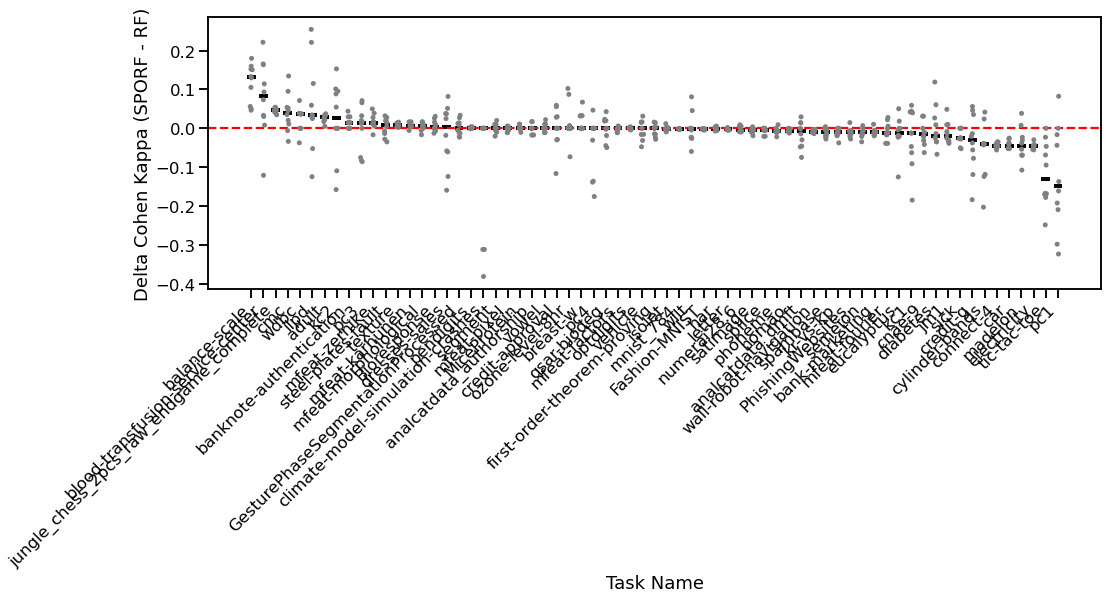

In [152]:
sns.set_context(
    "talk",
    #                 font_scale=1.25
)
fig, ax = plt.subplots(figsize=(16, 5))

sns.stripplot(
    x="task",
    y="delta_cohen_kappa",
    data=diff_df_melt,
    color="gray",
    order=order.index,
    ax=ax,
)

# distance across the "X" or "Y" stipplot column to span, in this case 40%
median_width = 0.4
df = diff_df_melt
for tick, text in zip(ax.get_xticks(), ax.get_xticklabels()):
    sample_name = text.get_text()  # "X" or "Y"

    # calculate the median value for all replicates of either X or Y
    median_val = df[df["task"] == sample_name]["delta_cohen_kappa"].median()

    # plot horizontal lines across the column, centered on the tick
    ax.plot(
        [tick - median_width / 2, tick + median_width / 2],
        [median_val, median_val],
        lw=4,
        color="k",
    )
ax.axhline([0], color="red", ls="--", label="No Change")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

ax.set(ylabel="Delta Cohen Kappa (SPORF - RF)", xlabel="Task Name")
# fig.tight_layout()
print("done")

# Pairplot

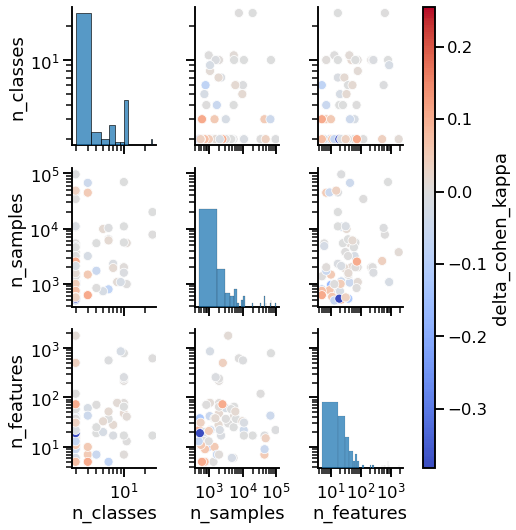

In [174]:
continuous_pairplot(
    diff_df_melt,
    vars=["n_classes", "n_samples", "n_features"],
    hue="delta_cohen_kappa",
    cmap="coolwarm",
)

# Analysis based on count

In [121]:
diff_df_melt["relative_rank"] = diff_df_melt["delta_cohen_kappa"]
diff_df_melt["relative_rank"] = diff_df_melt["relative_rank"].where(
    diff_df_melt["relative_rank"] < 0, other=1
)
diff_df_melt["relative_rank"] = diff_df_melt["relative_rank"].where(
    diff_df_melt["relative_rank"] == 1, other=0
)

display(diff_df_melt.head())

,task,n_samples,n_classes,task_id,cv_fold,delta_cohen_kappa,relative_rank
0,segment,2310,7,146822,0,-0.020202,0.0
1,jungle_chess_2pcs_raw_endgame_complete,44819,3,167119,0,0.053765,1.0
2,tic-tac-toe,958,2,49,0,-0.167665,0.0
3,pc1,1109,2,3918,0,-0.323811,0.0
4,analcatdata_dmft,797,6,3560,0,0.013671,1.0


In [123]:
diff_df_melt.groupby("relative_rank").count()

,task,n_samples,n_classes,task_id,cv_fold,delta_cohen_kappa
relative_rank,,,,,,
0.0,348,348,348,348,348,348
1.0,322,322,322,322,322,322


# Analysis based on number of classes

In [87]:
# compute descending order by median
order = (
    diff_df_melt.groupby("n_classes")
    .median()
    .sort_values(by="delta_cohen_kappa", ascending=False)
)

done


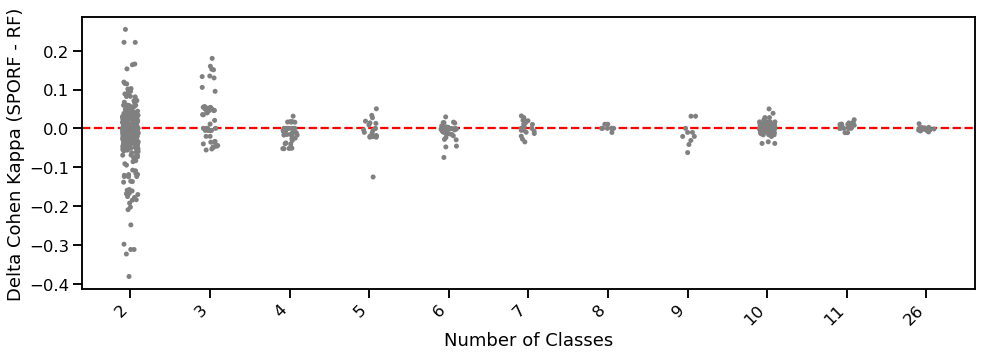

In [90]:
sns.set_context(
    "talk",
    #                 font_scale=1.25
)
fig, ax = plt.subplots(figsize=(16, 5))

sns.stripplot(
    x="n_classes",
    y="delta_cohen_kappa",
    data=diff_df_melt,
    color="gray",
    #     order=order.inde,x,
    ax=ax,
)

# distance across the "X" or "Y" stipplot column to span, in this case 40%
median_width = 0.4
df = diff_df_melt
for tick, text in zip(ax.get_xticks(), ax.get_xticklabels()):
    sample_name = text.get_text()  # "X" or "Y"

    # calculate the median value for all replicates of either X or Y
    median_val = df[df["n_classes"] == sample_name]["delta_cohen_kappa"].median()

    # plot horizontal lines across the column, centered on the tick
    ax.plot(
        [tick - median_width / 2, tick + median_width / 2],
        [median_val, median_val],
        lw=10,
        color="k",
    )
ax.axhline([0], color="red", ls="--", label="No Change")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

ax.set(ylabel="Delta Cohen Kappa (SPORF - RF)", xlabel="Number of Classes")
# fig.tight_layout()
print("done")